In [15]:
import h5py
import numpy as np
fh5 = h5py.File('d:/h5/fmap_cf.h5','r')
img = fh5['map']
img = np.array(img)
print(img.shape)
lab = fh5['lab']
lab = np.array(lab)
print(lab.shape)

(11074, 33, 33)
(11074,)


In [16]:
img = img.reshape(len(img), 33, 33, 1)


In [10]:
ll = ['BLCA', 'BRCA', 'CESC', 'COAD', 'ESCA', 'GBM', 'HNSC', 'KIBP','KICH','KIRC', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC',
      'OV', 'PAAD','PARD','PCPG', 'PRAD','READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC']

In [11]:
lll = ['BLCA', 'BRCA', 'CESC', 'COAD', 'ESCA', 'GBM', 'HNSC', 'KIRP','KICH','KIRC', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC',
      'OV', 'PAAD','PRAD','PCPG','READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC']

In [12]:
labg = np.zeros(len(lab)) 

In [19]:
for i in range(len(lab)):
    if lab[i]==19:
        labg[i] = 17
    if lab[i]>=20:
        labg[i] = lab[i]-1
    else:
        labg[i] = lab[i]

In [20]:
labg

array([ 0.,  0.,  0., ..., 26., 26., 26.])

In [17]:
lab

array([ 0.,  0.,  0., ..., 27., 27., 27.])

In [21]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(labg)
train_labels.shape

(11074, 27)

In [22]:
train_labels.shape

(11074, 27)

In [5]:
lab

array([ 0.,  0.,  0., ..., 27., 27., 27.])

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(img,train_labels,test_size=0.25,random_state=1)

In [24]:
from keras import models
from keras import layers
from keras.models import Sequential,Input
from keras import optimizers
import keras
from keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Flatten,Dense,Lambda,Multiply,AveragePooling2D,Activation
from keras.models import Model

Using TensorFlow backend.


In [6]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10),
    keras.callbacks.ModelCheckpoint(filepath='e:/data/rmap.h5',monitor='val_loss',save_best_only=True)   ##保存最佳模型
    ]

In [25]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='valid',strides=(1,1),data_format='channels_last',dilation_rate=(1,1),
              activation='relu',name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
# inception 模块和 xception模块 bn层位置不一样

    #x = BatchNormalization(name=bn_name)(x)
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,data_format='channels_last',activation='relu',
               dilation_rate=dilation_rate,name=conv_name)(x)
    x = BatchNormalization(name=bn_name)(x)
    
    return x

In [26]:
def InceptionB(x,nb_filter):
    branch_1x1_t = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Activation('sigmoid')(branch_1x1_s)
    branch_1x1_c = keras.layers.Multiply()([branch_1x1_t,branch_1x1_s])
    
    branch_3x3_t = Conv2d_BN(x,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_3x3_s = Conv2d_BN(x,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_3x3_s = Activation('sigmoid')(branch_3x3_s)
    branch_3x3_c = keras.layers.Multiply()([branch_3x3_t,branch_3x3_s])
       
    branch_5x5_t = Conv2d_BN(x,nb_filter,(5,5), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_5x5_s = Conv2d_BN(x,nb_filter,(5,5), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_5x5_s = Activation('sigmoid')(branch_5x5_s)
    branch_5x5_c = keras.layers.Multiply()([branch_5x5_t,branch_5x5_s])
    

    x = keras.layers.Concatenate(axis=3)([branch_1x1_c,branch_3x3_c,branch_5x5_c]) #

    return x

In [27]:
def InceptionC(x,nb_filter):
    branch_1x1_t = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Activation('sigmoid')(branch_1x1_s)
    branch_1x1_c = keras.layers.Multiply()([branch_1x1_t,branch_1x1_s])
    
    branch_3x3_t = Conv2d_BN(x,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_3x3_s = Conv2d_BN(x,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_3x3_s = Activation('sigmoid')(branch_3x3_s)
    branch_3x3_c = keras.layers.Multiply()([branch_3x3_t,branch_3x3_s])
    

    x = keras.layers.Concatenate(axis=3)([branch_1x1_c,branch_3x3_c]) #branch_1x1_c,

    return x

In [36]:
def TestNet(input_shape=None):
    inpt = Input(shape=input_shape)
    #padding = 'same'，填充为(步长-1）/2,还可以用ZeroPadding3D((3,3,3))
    x = Conv2d_BN(inpt,32,(3,3),strides=(1,1),padding='same')
    x = InceptionB(x,64)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
    x = InceptionB(x,128)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
    x = InceptionC(x,256)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
    x = InceptionC(x,256)
    x = AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(27,activation='softmax')(x)
    model = Model(inpt,x,name='inception')
    
 
    return model

In [37]:
model = TestNet(input_shape=(33,33,1))
model.summary()

Model: "inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 33, 33, 1)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 33, 33, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 33, 33, 32)   128         conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 33, 33, 64)   2112        batch_normalization_22[0][0]     
__________________________________________________________________________________________

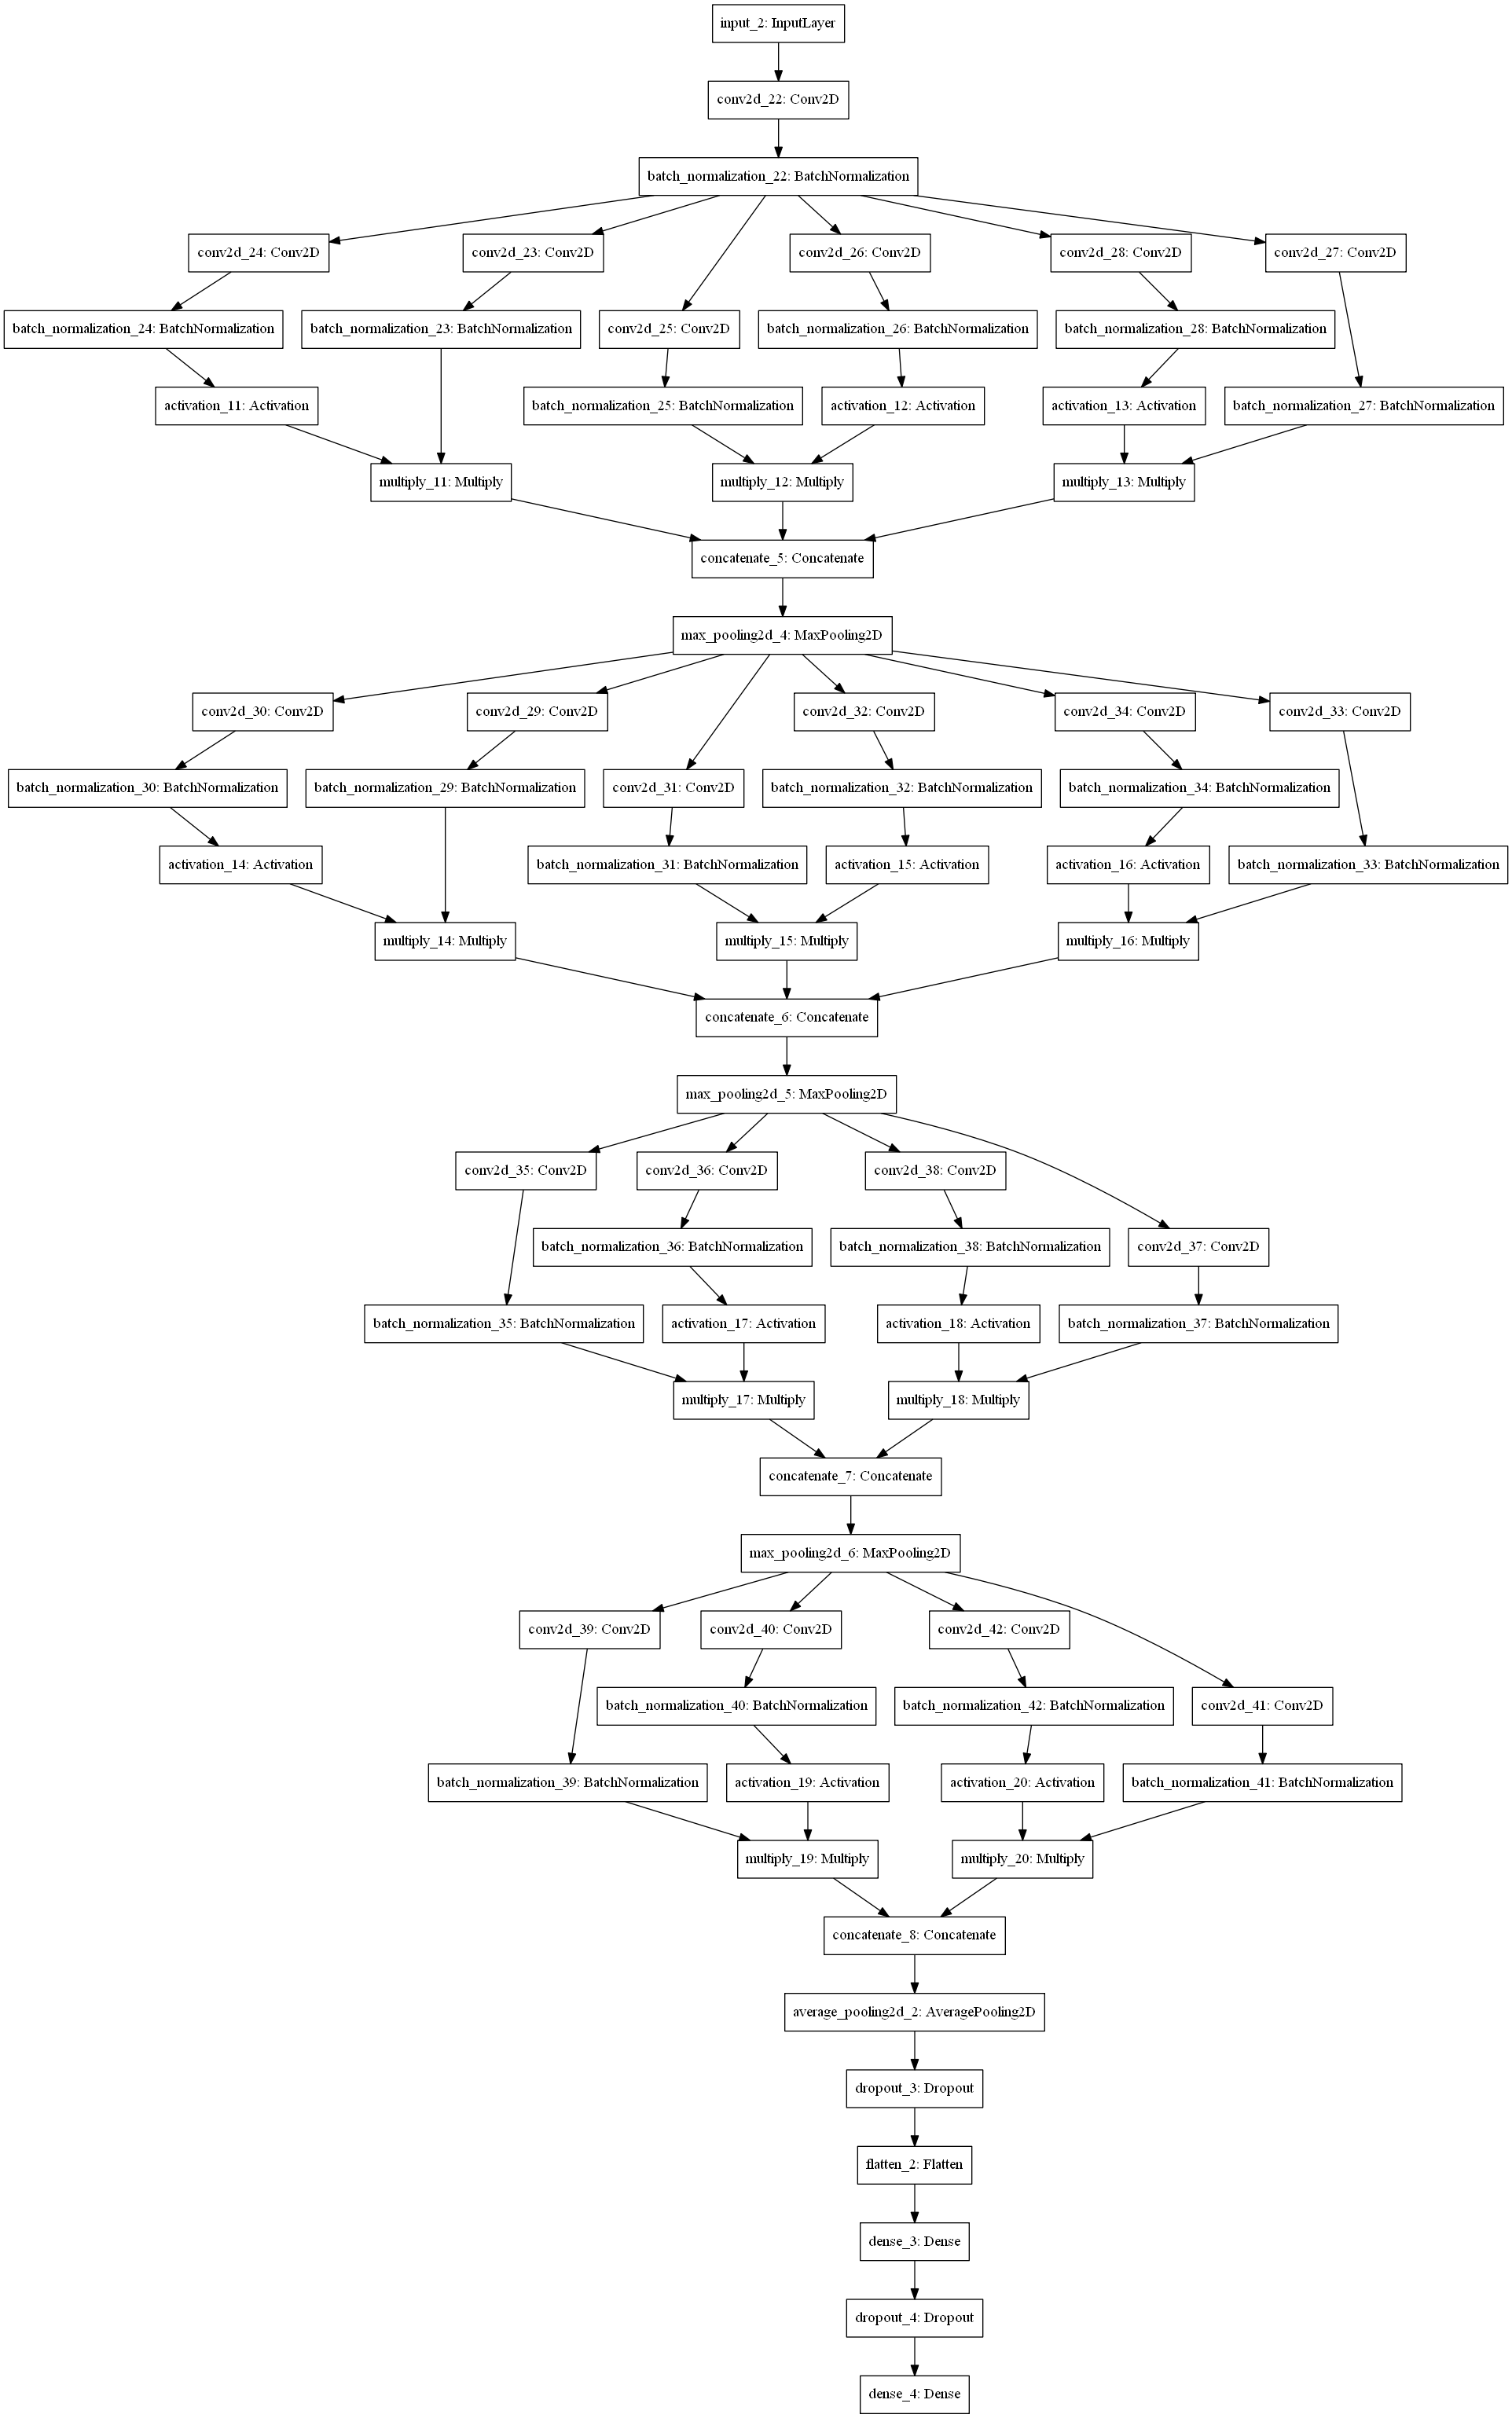

In [38]:
from tensorflow.keras.utils import plot_model     ##模型结构图
plot_model(model, 'd:\\h5\\model_3d.png')

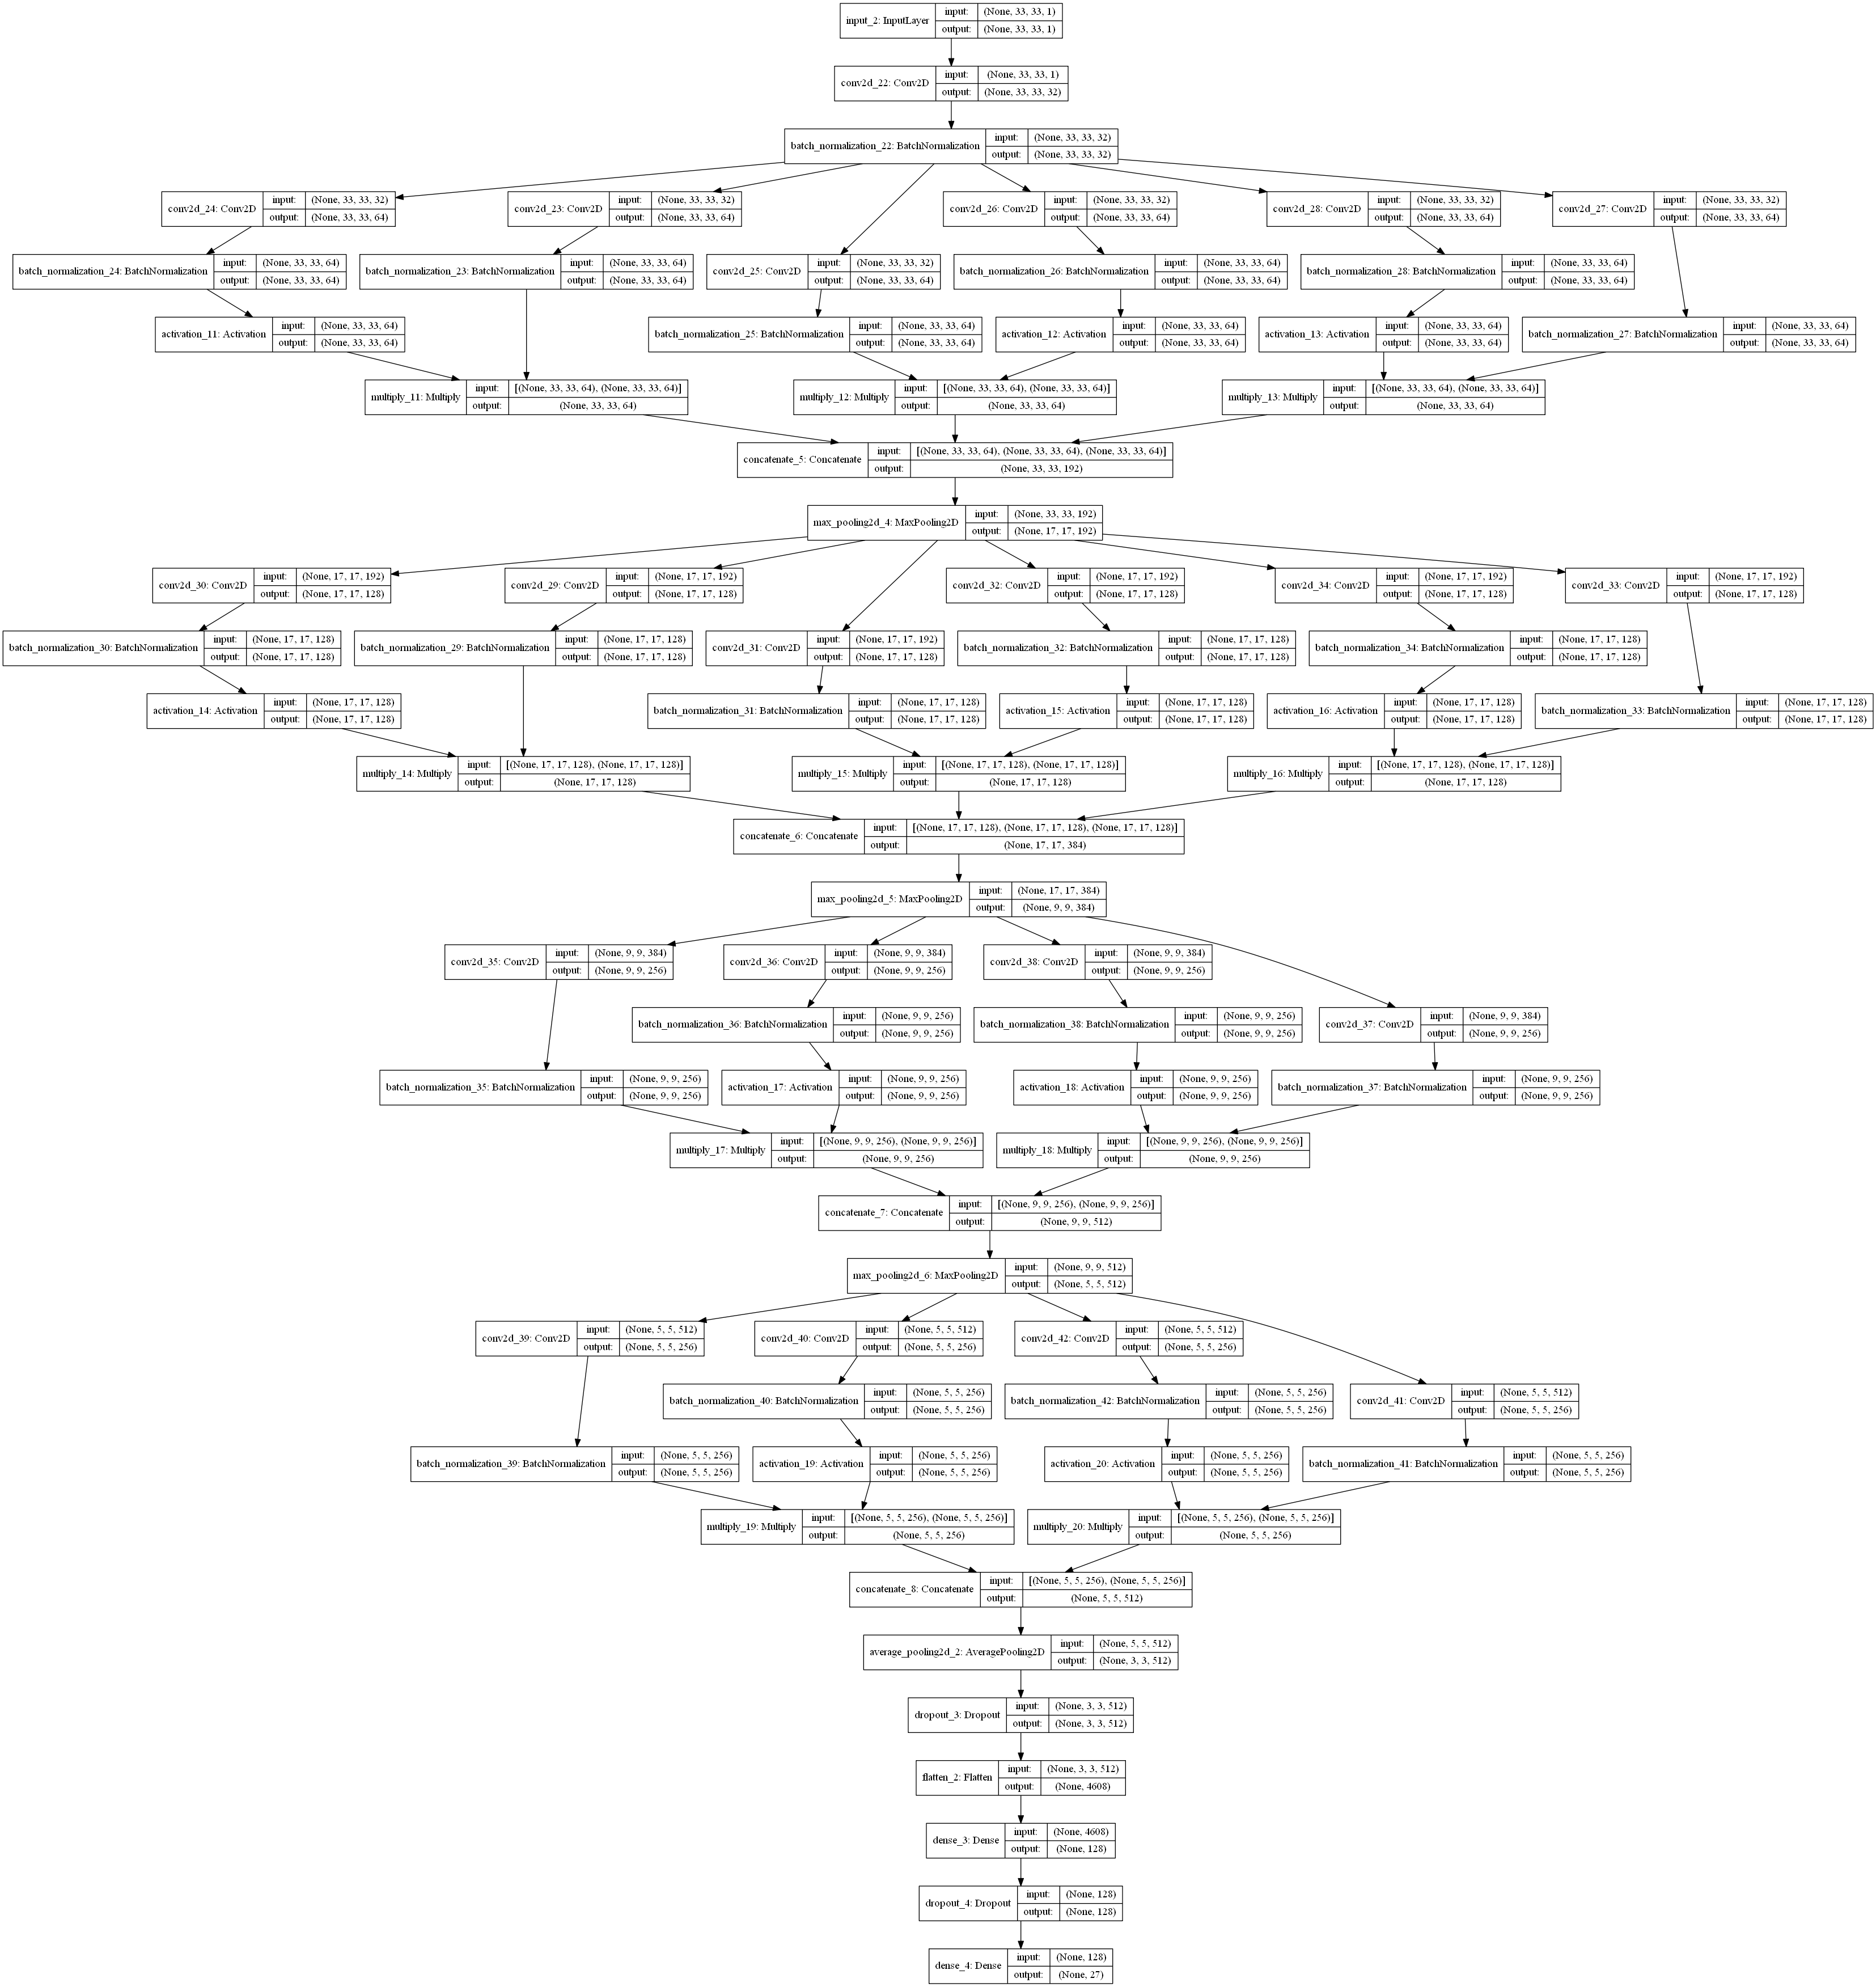

In [39]:
plot_model(model, 'd:\\h5\\model_3d.png',show_shapes=True)

In [40]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [47]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),#
              metrics=['acc']
              #metrics=['acc','Precision','Recall'] 
             )

In [56]:
his = model.fit(X_train,y_train,epochs=100,batch_size=64)#,callbacks = callbacks_list,validation_split=0.25

Epoch 1/100
8305/8305 [==============================] - 8s 987us/step - loss: 0.0058 - acc: 0.9964
Epoch 2/100
8305/8305 [==============================] - 8s 936us/step - loss: 0.0060 - acc: 0.9957
Epoch 3/100
8305/8305 [==============================] - 8s 938us/step - loss: 0.0061 - acc: 0.9954
Epoch 4/100
8305/8305 [==============================] - 8s 936us/step - loss: 0.0060 - acc: 0.9955
Epoch 5/100
8305/8305 [==============================] - 8s 941us/step - loss: 0.0060 - acc: 0.9953
Epoch 6/100
8305/8305 [==============================] - 8s 942us/step - loss: 0.0060 - acc: 0.9952
Epoch 7/100
8305/8305 [==============================] - 8s 938us/step - loss: 0.0058 - acc: 0.9965
Epoch 8/100
8305/8305 [==============================] - 8s 943us/step - loss: 0.0059 - acc: 0.9963
Epoch 9/100
8305/8305 [==============================] - 8s 966us/step - loss: 0.0058 - acc: 0.9961
Epoch 10/100
8305/8305 [==============================] - 8s 1ms/step - loss: 0.0059 - acc: 0.9961
E

In [57]:
test_loss,test_acc= model.evaluate(X_test,y_test)
print('test_acc:',test_acc)

2769/2769 [==============================] - 1s 460us/step
test_acc: 0.9035753011703491


In [22]:
#label = np.argmax(y_test, axis=1)

In [58]:
predict = model.predict(X_test)
predict=np.argmax(predict,axis=1)

In [59]:
y_test2=np.argmax(y_test,axis=1)

In [60]:
predict.shape

(2769,)

In [61]:
predict

array([26, 26, 22, ..., 13, 22,  0], dtype=int64)

In [62]:
from sklearn.metrics import classification_report
print('查准率、查全率、F1值：')
print(classification_report(y_test2,predict,target_names=lll))

查准率、查全率、F1值：
              precision    recall  f1-score   support

        BLCA       0.84      0.78      0.81       124
        BRCA       0.99      0.99      0.99       306
        CESC       0.83      0.83      0.83        75
        COAD       0.84      0.89      0.86       137
        ESCA       0.85      0.64      0.73        53
         GBM       1.00      0.95      0.97        40
        HNSC       0.89      0.93      0.91       180
        KIRP       0.92      0.80      0.86        30
        KICH       0.95      0.97      0.96       183
        KIRC       0.98      0.91      0.95        69
        LAML       1.00      1.00      1.00        26
         LGG       0.98      0.99      0.98       131
        LIHC       0.97      0.98      0.97       116
        LUAD       0.84      0.87      0.86       134
        LUSC       0.85      0.84      0.85       139
          OV       0.98      0.99      0.98        92
        PAAD       0.94      0.92      0.93        51
        PRAD  

In [63]:
model.save_weights('d:/h5/fmap_cf_weights.h5')